# brings new insights into current trends regarding localities, topics and events.

# 1. important!: open neo4j, gather required libraries

In [1]:
import os
import csv
from neo4j import GraphDatabase, basic_auth

import matplotlib.pyplot as plt

#currently neo4j is running on localhost
neo4jUrl = os.environ.get('NEO4J_URL',"bolt://192.168.99.100")
neo4jUser = os.environ.get('NEO4J_USER',"neo4j")
neo4jPass = os.environ.get('NEO4J_PASSWORD',"1")

driver = GraphDatabase.driver(neo4jUrl, auth=basic_auth(neo4jUser, neo4jPass))

graph = driver.session()

# 2. parameters for Cypher-queries
- The desired time periods aggregation can be set with the variable "selectedAggregation".
-- 0 stands for the date; 
-- 1 stands for the month;
-- 2 stands for the week;
-- 3 stands for the hour of a day
- The desired number of top values can be specified with the variable "amountOfReturnValues". 
e.g. value 5 for the top five results

In [2]:
# 0 = date; 1=month; 2=week; 3=clock
dateAggregationOptions = ["date(datetime({epochmillis:toInt(e.time)}))", "date.truncate('month',datetime({epochmillis:toInt(e.time)}))", "date.truncate('week',datetime({epochmillis:toInt(e.time)}), {dayOfWeek:2})" , "time.truncate('hour',(datetime({epochmillis:toInt(e.time)})))"]
selectedAggregation = 1
dateAggregation = dateAggregationOptions[selectedAggregation]
amountOfReturnValues = "8"



# 3. prepare function for printing pie chart

In [3]:
def printPieChart(date2,data, chartLabels):
    dateAggregationOptionsForChartTitle = ["", "month", "week of", "hour"]
    dateAggregationForChartTitle = dateAggregationOptionsForChartTitle[selectedAggregation]
    
    from datetime import date
    from datetime import datetime
    
  #  datetime_object = datetime.strptime(str(date2), '%b %d %Y %I:%M%p')
    
    if (selectedAggregation == 0):
       # date = date.strftime(date2,'%A %d %B %Y')
      #  date2 = datetime.strptime(str(date2),'%Y-%m-%d')
      #  date2 = date.strftime(date2,'%Y-%m-%d %H:%M:%S')
        date2 = datetime.strptime(str(date2),'%Y-%m-%d').strftime('%A %d %B %Y')
    if (selectedAggregation == 1):
        date2 = datetime.strptime(str(date2),'%Y-%m-%d').strftime('%B %Y')
    if (selectedAggregation == 2):
        dayOfWeek = datetime.strptime(str(date2),'%Y-%m-%d').strftime('%d %B %Y')
        week = datetime.strptime(str(date2),'%Y-%m-%d').strftime('%W')
        date2 = str(dayOfWeek)+" (Week: "+str(week)+")"
    if (selectedAggregation == 3):
        date2 = datetime.strptime(str(date2),'%H:%M:%S.%f000').strftime('%H')

 
    plt.suptitle('Aggregated to the '+dateAggregationForChartTitle+" "+ str(date2) +" (Top: "+amountOfReturnValues+")", fontsize=16)
    labels = chartLabels
    sizes = data
    patches, l, texts = plt.pie(sizes, shadow=True, startangle=90, autopct='%0.1f%%')
  #  plt.legend(patches, labels, loc="best")
    plt.legend(patches,labels, bbox_to_anchor=(1,0.5), loc="center left", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
    plt.axis('equal')
    plt.show()    
    
    

# Top Events (measured at RSVP-amount)
Executes according to settings in step 2.

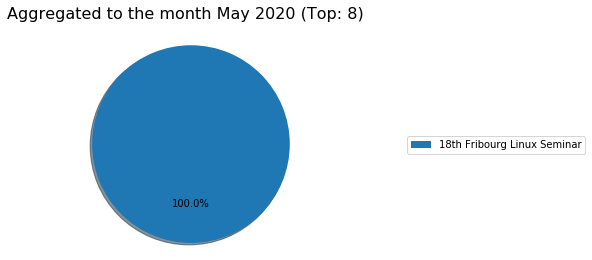

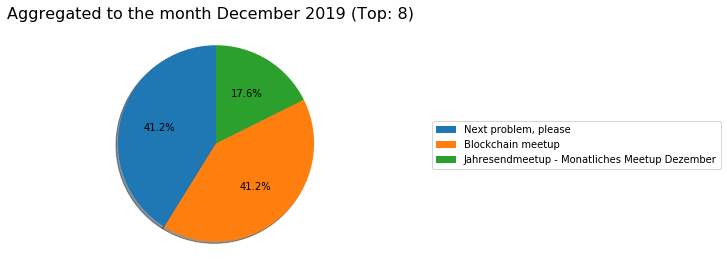

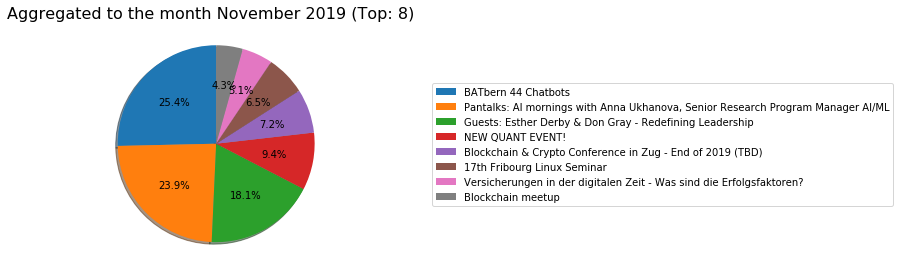

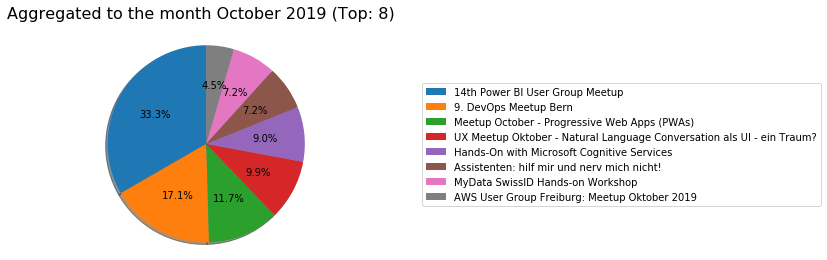

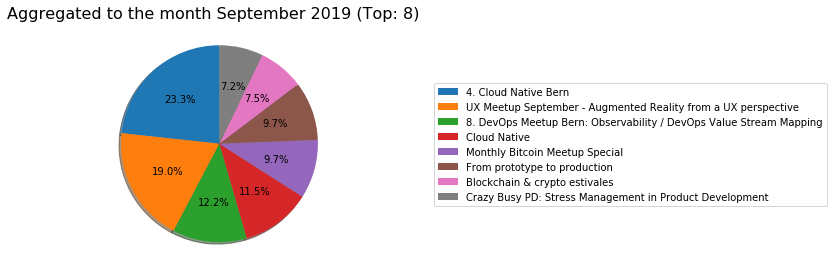

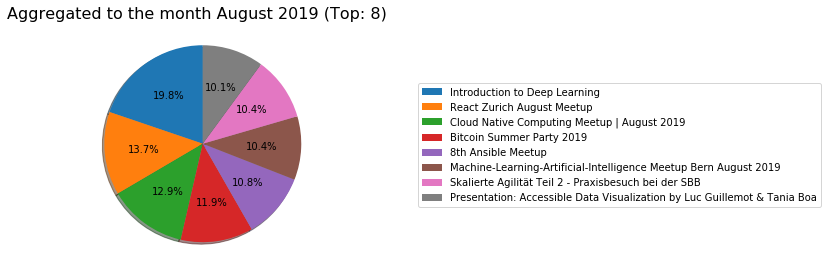

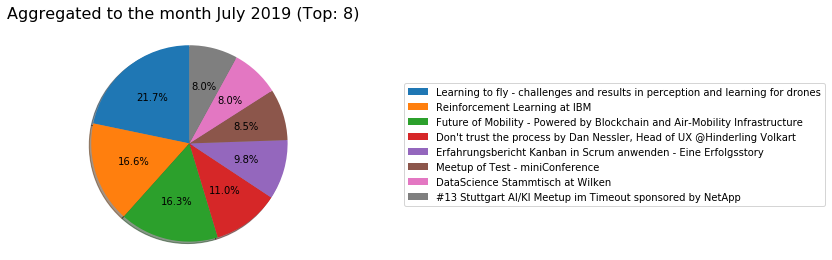

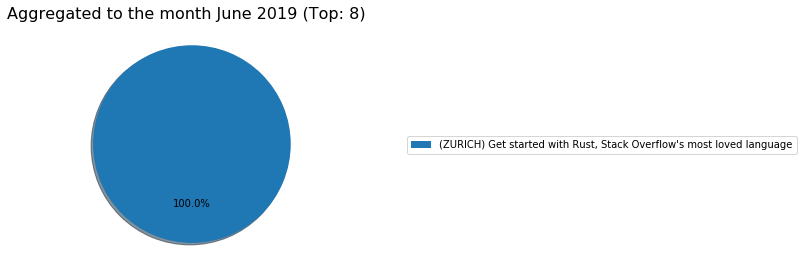

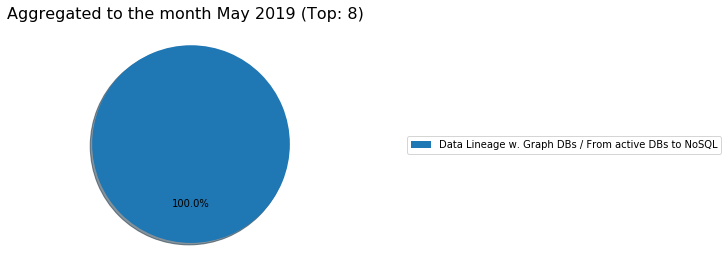

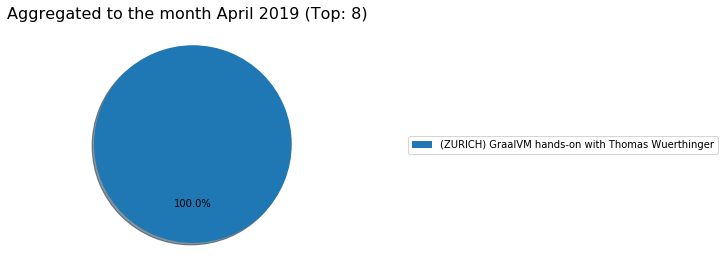

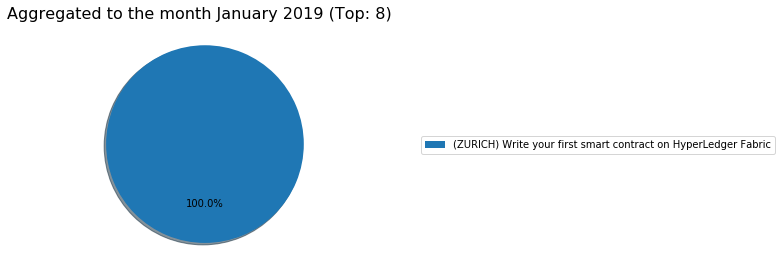

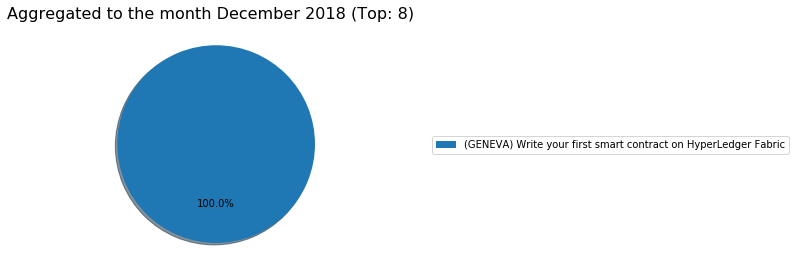

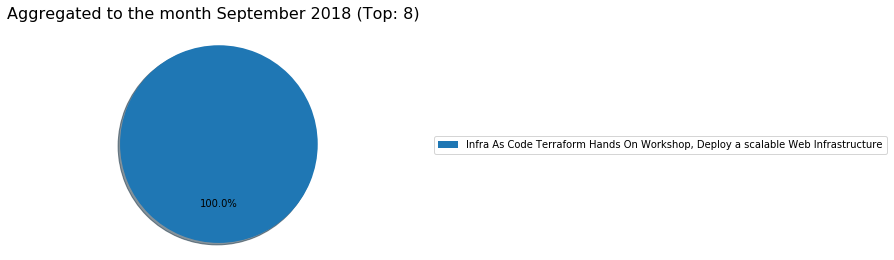

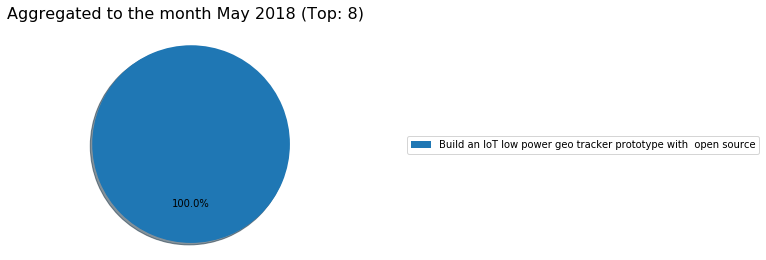

In [8]:
def get_top_events(tx):
    for record in tx.run("match (e:Event)<-[r:RSVPd]-(p:Person) with "+dateAggregation+" as date, count(r) as rsvp_count, e.name as name  order by rsvp_count desc return date, collect(rsvp_count)[.."+amountOfReturnValues+"] as rsvp_amount, collect(name)[.."+amountOfReturnValues+"] as event_name order by date desc"):
    
        rsvpcount_events = list(zip(record['rsvp_amount'], record['event_name']))
        
        printPieChart(record["date"],record['rsvp_amount'],record['event_name'])
 #       printPieChartModern(record["date"],record['rsvp_amount'],record['event_name'])
 #       tablePrint(record["date"], rsvpcount_events, ['rsvp_amount', 'event_name'])
                
with driver.session() as session:
    session.read_transaction(get_top_events)
    


# Top topics: Ranking of the topics with the highest number of events
Executes according settings in step 2.

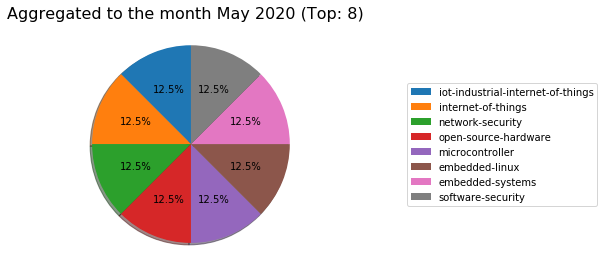

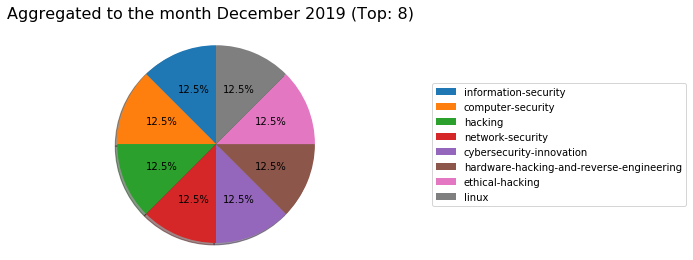

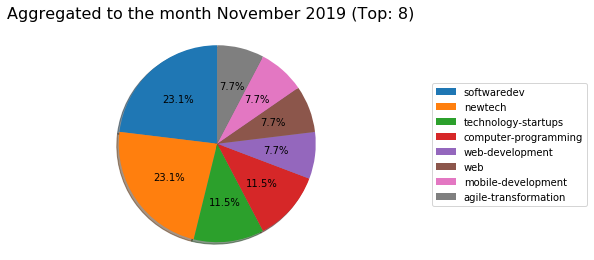

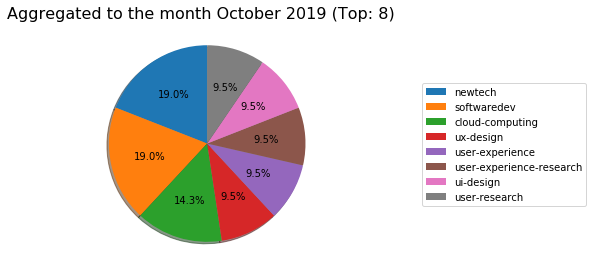

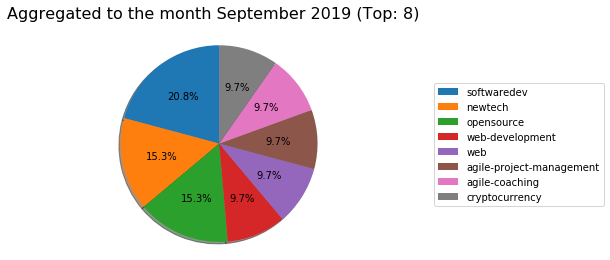

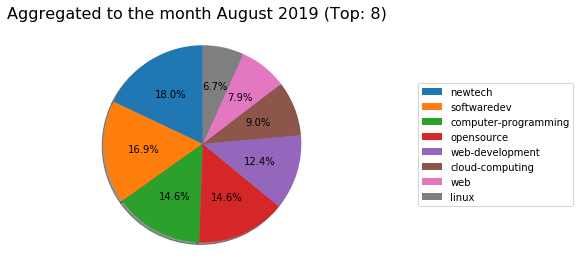

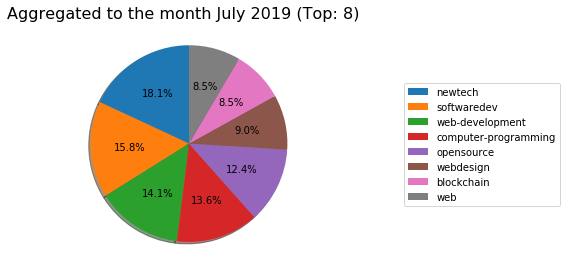

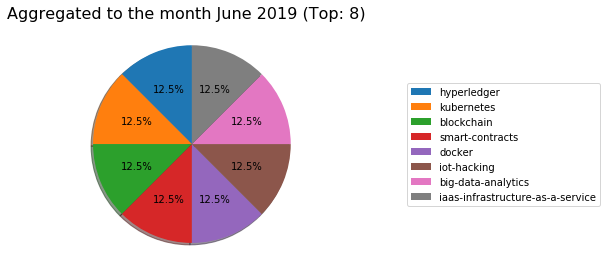

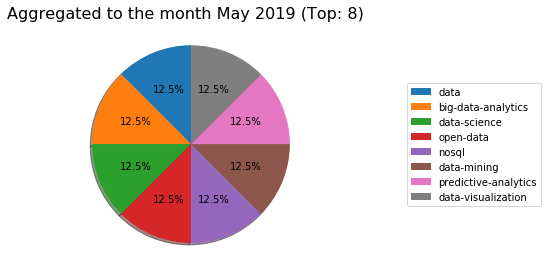

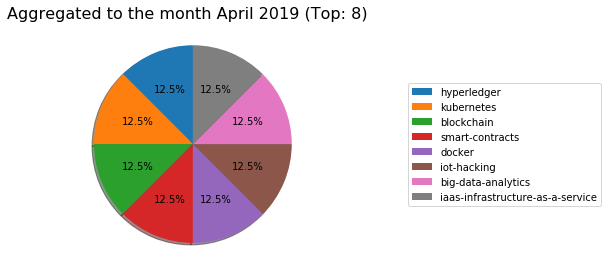

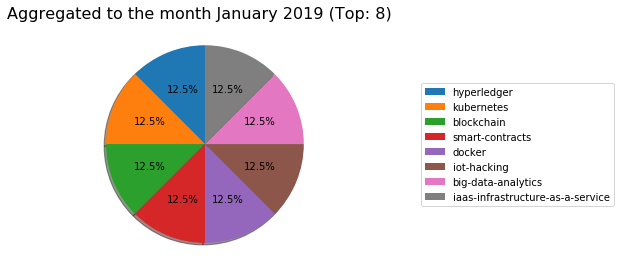

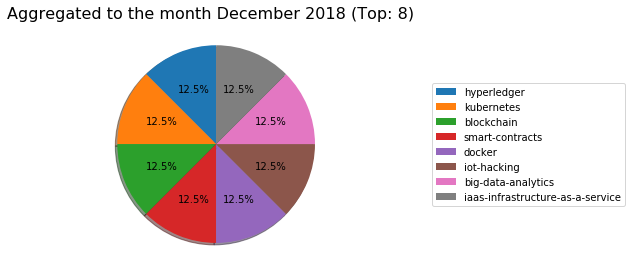

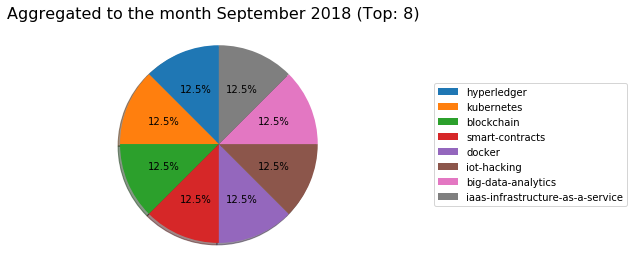

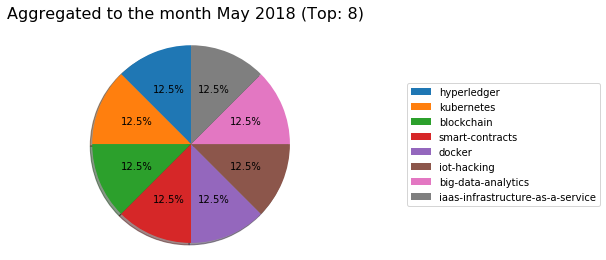

In [7]:
def get_hot_topics(tx):
    for record in tx.run("match(e:Event)<-[:ORGANIZES]-(g:Group)-[:IS_ABOUT]->(t:Topic) with "+dateAggregation+" as date, t.urlkey as topic, count(e) as amount_events_per_topic order by amount_events_per_topic desc return date, collect(amount_events_per_topic)[.."+amountOfReturnValues+"] as events_amount, collect(topic)[.."+amountOfReturnValues+"] as topic order by date desc"):
        events_per_topics = list(zip(record['events_amount'], record['topic']))

       # tablePrint(record["date"], events_per_topics, ['events_amount', 'topic'])
        printPieChart(record["date"],record['events_amount'],record['topic'])

with driver.session() as session:
    session.read_transaction(get_hot_topics)

# Top locations

# important!: This cell must be executed before location analysis.
Configurations for the analysis are made here.
If "latLonRoundedToDecimalPlace10" is set to true, the results will be aggregated to the city by rounding longitudes and latitudes to 10 decimal places. If the named variable is set to false, the results will be aggregated to the city.

In [5]:
latLonRoundedToDecimalPlace10 = False
if latLonRoundedToDecimalPlace10 == True:
    latLon = "round(toFloat(v.lat)*10)/10 as lat, round(toFloat(v.lon)*10)/10 as lon"
else:
    latLon = "toFloat(v.lat) as lat, toFloat(v.lon) as lon"

# Top locations: aggregated to city/address
The map information is fetched using "openstreetmap" with the given longitudes and latitutdes.
(Executes according to settings in step 2 and the location aggregation settings from the above cell)

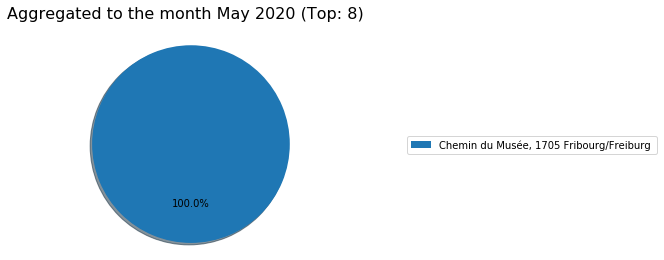

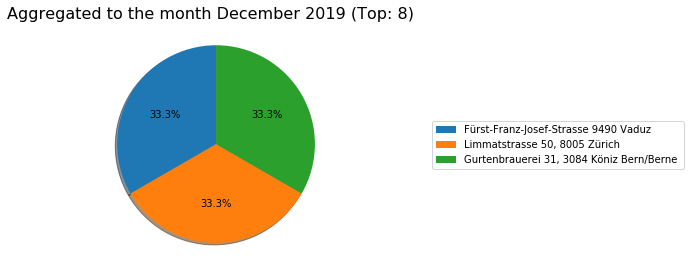

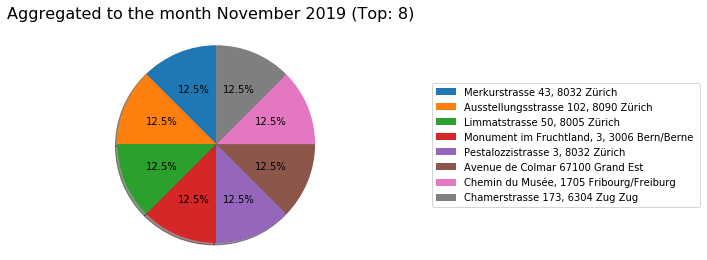

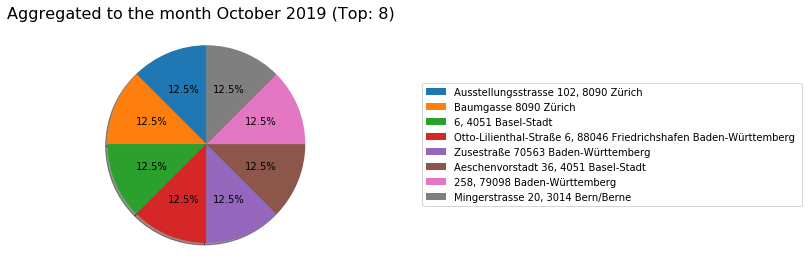

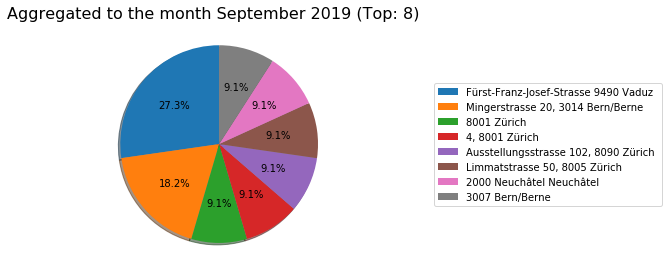

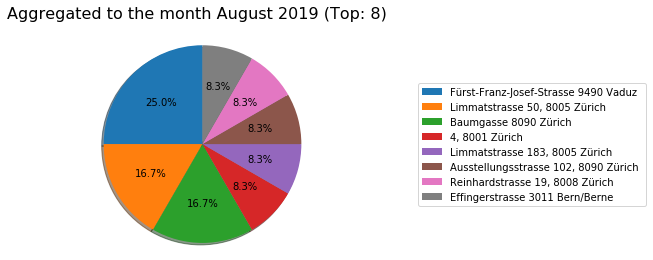

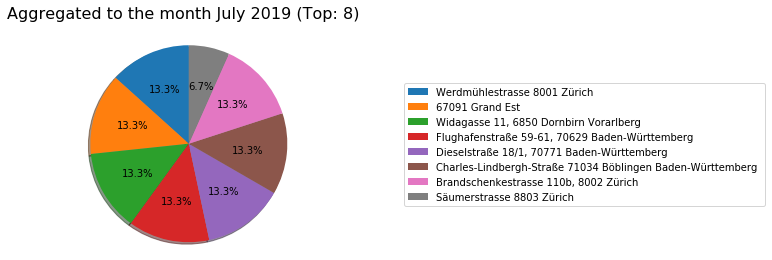

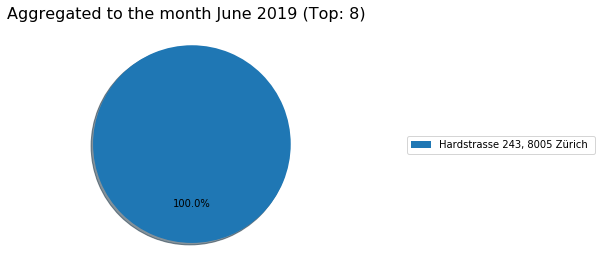

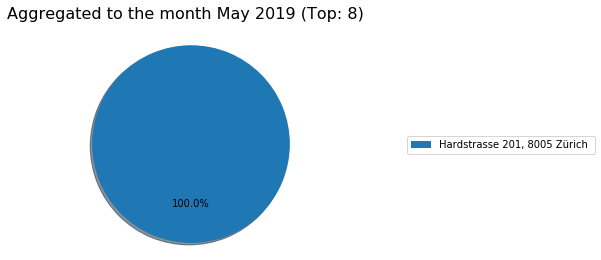

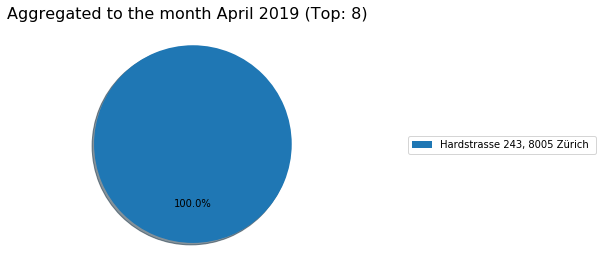

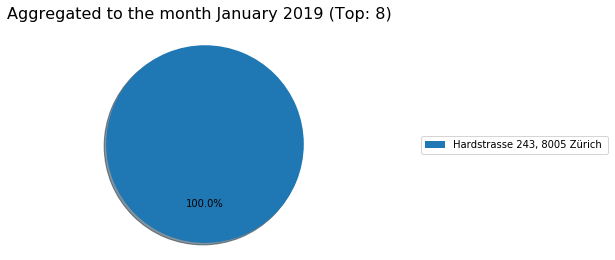

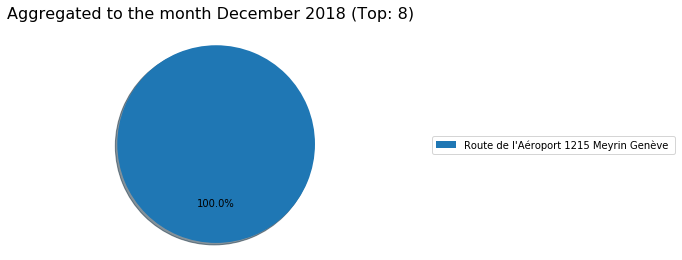

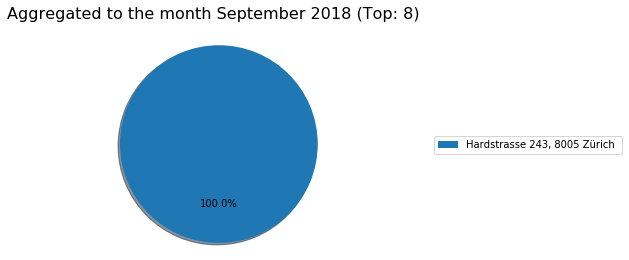

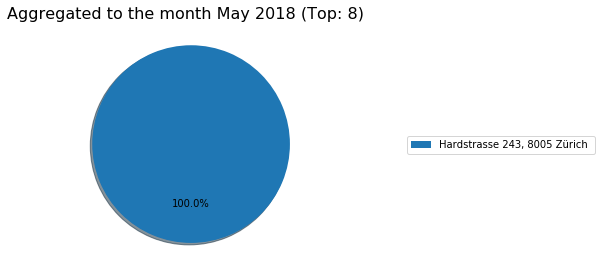

In [6]:

from geopy.geocoders import Nominatim
def get_hot_locations(tx):
    for record in tx.run("match(e:Event)-[:TAKES_PLACE_AT]->(v:Venue) where not v.address = '' and  not v.city=''  with "+dateAggregation+" as date, "+latLon+", count(*) as amount_events_at_location order by  amount_events_at_location desc  return date, collect(amount_events_at_location)[.."+amountOfReturnValues+"] as events_amount, collect(lon)[.."+amountOfReturnValues+"] as lon, collect(lat)[.."+amountOfReturnValues+"]  as lat order by date desc "):
        
        geolocator = Nominatim(user_agent="specify_your_app_name_here")
       # location = geolocator.reverse("52.509669, 13.376294")

        addresses = []
        
        for lat, lon in zip(record['lat'], record['lon']):
            location = geolocator.reverse([lat,lon], timeout=10, addressdetails=True)
            address = location.raw['address']
            
            road = ""
            state =""
            town=""
            house_number=""
            postcode = ""
            footway = ""
            
            if (latLonRoundedToDecimalPlace10 == False):
                if 'road' in address:
                    road =  address['road']
                    road += " "
                if 'house_number' in address:
                    house_number = address['house_number']
                    house_number += ", "
                if 'footway' in address:
                    footway = address['footway']
                    footway += ", "
                if 'postcode' in address:
                    postcode = address['postcode']
                    postcode += " "
            if 'state' in address:
                state = address['state']
                state += " "
            if 'town' in address:
                town = address['town']
                town += " "
      
            addresses.append(footway+road+house_number+postcode+town+state)


           # events_in_cities = list(zip(record['events_amount'], record['city']))
        
        printPieChart(record["date"],record['events_amount'],addresses)
       # tablePrint(record["date"], events_in_cities, ['events_amount', 'city'])
    
with driver.session() as session:
    session.read_transaction(get_hot_locations)

# close neo4j connection

In [ ]:
graph.close()